In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import igpu
import cupy as cp
import pickle

In [2]:
mice = ["mpfc14", "mpfc19", "mpfc20", "mpfc23", "mpfc24", "mpfc30"]
days = ["yd1", "yd2", "yd6"]

In [7]:
h = []
w = []
for mi, mouse in enumerate(mice):
    ws = []
    hs = []
    for di, day in enumerate(days):
        i = 0
        wss = []
        while True:
            try:
                df = pd.read_csv(mouse + "/" + mouse + "_" + day + "_igpu_Wlim001_W" + str(i) + ".csv", header=None).values
                wss.append(df)
                i += 1
            except:
                break
        ws.append(wss)
        hs.append(pd.read_csv(mouse + "/" + mouse + "_" + day + "_igpu_Wlim001_H.csv", header=None).values)
    w.append(ws)
    h.append(hs)
    
beh = []
for mi, mouse in enumerate(mice):
    behs = []
    for di, day in enumerate(days):
        df = pd.read_csv("behavior/" + mouse + "/" +mouse + "_" + day + ".csv", header=None).values
        
        # remove "just-in-case" lick
        n = len(df[:, 0])
        t = np.zeros(n)
        for i in range(1, n-1):
            if df[i, 0] == 1:
                t[i] = 1
            else:
                if df[i-1, 0] == 1 and df[i+1, 0] == 1:
                    t[i] = 1
        df[:, 0] = t.copy()
        
        behs.append(df)
    beh.append(behs)

In [9]:
with open("w_single_Wlim001.pkl", "rb") as f:
    w_single = pickle.load(f)
with open("h_single_Wlim001.pkl", "rb") as f:
    h_single = pickle.load(f)
with open("h_spike_Wlim001.pkl", "rb") as f:
    h_spike = pickle.load(f)

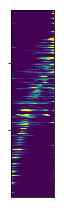

In [83]:
mi = 4
di = 2
wi = 0
th = w[mi][di][wi].mean() + 3 * w[mi][di][wi].std()
plt.figure(figsize=(1, 3))
plt.pcolor(w[mi][di][wi][w_single[mi][di][wi][:, 1].argsort()], vmax=th)
plt.yticks([200, 400])
plt.tick_params(labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig3/fig3a_w.png")

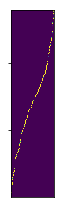

In [84]:
tmp = np.zeros_like(w[mi][di][wi])
for i, (a, p) in enumerate(w_single[mi][di][wi]):
    tmp[i, int(p)] = a
th = w[mi][di][wi].mean() + 3 * w[mi][di][wi].std()
plt.figure(figsize=(1, 3))
plt.pcolor(tmp[w_single[mi][di][wi][:, 1].argsort()], vmax=th)
plt.yticks([200, 400])
plt.tick_params(labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig3/fig3b_w.png")

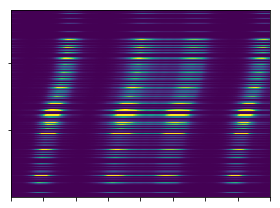

In [85]:
start = 2000
u = cp.asnumpy(igpu.single.conv_single(
    cp.array(w_single[mi][di][wi][:, 0][:, cp.newaxis]),
    cp.array(w_single[mi][di][wi][:, 1][:, cp.newaxis]),
    cp.array(h_single[mi][di][start:start+449, wi:wi+1]).T, 50, 1e-7)).T
plt.figure(figsize=(4, 3))
plt.pcolor(u.T[w_single[mi][di][wi][:, 1].argsort()], vmax=u.mean()+5*u.std())
plt.yticks([200, 400])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig3/fig3b_v.png")

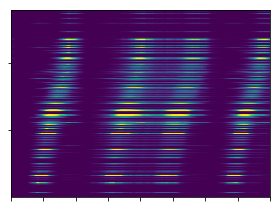

In [86]:
u = cp.asnumpy(igpu.conv(cp.array(w[mi][di][wi][:, np.newaxis, :]), cp.array(h[mi][di][:, wi:wi+1]).T, 1e-7)).T[start:start+400]
plt.figure(figsize=(4, 3))
plt.pcolor(u.T[w_single[mi][di][wi][:, 1].argsort()], vmax=u.mean()+5*u.std())
plt.yticks([200, 400])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig3/fig3a_v.png")

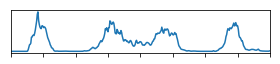

In [87]:
plt.figure(figsize=(4, 1))
plt.plot(h[mi][di][start+49:start+449, wi])
plt.tick_params(left=False, labelleft=False, labelbottom=False)
plt.xlim(0, 400)
plt.tight_layout()
plt.savefig("paper/fig3/fig3a_h.png")

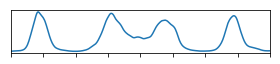

In [89]:
plt.figure(figsize=(4, 1))
plt.plot(h_single[mi][di][start+49:start+449, wi])
plt.tick_params(left=False, labelleft=False, labelbottom=False)
plt.xlim(0, 400)
plt.tight_layout()
plt.savefig("paper/fig3/fig3b_h.png")

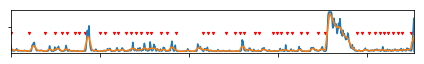

In [103]:
mi = 4
di = 2
wi = 2
move_ave = np.zeros_like(h_single[mi][di])
s = h_single[mi][di][:49].sum(axis=0)
num = 49
t = move_ave.shape[0]
for i in range(t):
    if i + 49 < t:
        num += 1
        s[:] += h_single[mi][di][i+49, :]
    move_ave[i, :] = s[:] / num
    if i - 49 > 0:
        num -= 1
        s[:] -= h_single[mi][di][i-49, :]
plt.figure(figsize=(6, 1))
plt.plot(h_single[mi][di][49:, wi], label="Occurrence")
plt.plot(move_ave[49:, wi], label="Moving Average")
plt.scatter(np.where(beh[mi][di][:, 2] == 1), np.ones(int(beh[mi][di][:, 2].sum())) * 300, marker="v", s=5, c="r", label="Reward")
plt.yticks([400])
plt.xticks([2000 * i for i in range(5)])
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlim(0, h_single[mi][di].shape[0] - 49)
plt.tight_layout()
plt.savefig("paper/fig3/fig3c.png")

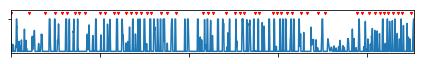

In [106]:
plt.figure(figsize=(6, 1))
plt.plot(h_spike[mi][di][49:, wi])
plt.scatter(np.where(beh[mi][di][:, 2] == 1), np.ones(int(beh[mi][di][:, 2].sum())) * 1.2, marker="v", s=5, c="r", label="Reward")
plt.yticks([1])
plt.xticks([2000 * i for i in range(5)])
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlim(0, h_single[mi][di].shape[0] - 49)
plt.tight_layout()
plt.savefig("paper/fig3/fig3d.png")